#### Base Settings

##### Library

In [1]:
# Library import

## pandas
import pandas as pd

import gdown
import zipfile as zf
from tqdm import tqdm
import nltk

import os
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import string
from collections import Counter
import random

# shikit learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import tensorflow as tf
import tensorflow as keras
from keras import layers, Input, Sequential, Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D, \
                                    TextVectorization
import tensorflow_datasets as tfds

##### Parmas

In [2]:
RAND_SEED = 83
random.seed(RAND_SEED)

NUM_TEXT_DATA       = 1         #üìå ÏÇ¨Ïö©Ìï† Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®
MAX_LENGTH          = 20            #üìå Î¨∏Ïû• Í∏∏Ïù¥
BATCH_SIZE          = 64
BUFFER_SIZE         = 20000
NUM_LAYERS          = 2
D_MODEL             = 512
NUM_HEADS           = 4
DFF                 = 256
DROPOUT             = 0.1
VOCAB_SIZE          = 10000
EPOCHS              = 10

### Data handling

In [3]:
def collect_json_file(path):
    """
    Ìè¥ÎçîÏùò jsonÌååÏùºÏùÑ Î™®Îëê Î∂àÎü¨ÏôÄ Î¶¨Ïä§Ìä∏Î°ú Î∞òÌôòÌïòÎäî Ìï®Ïàò
    """
    file_list = os.listdir(path)

    json_list = []
    for file_name in file_list:
        if '.json' in file_name:
            json_list.append(file_name)

    return json_list

In [4]:
def parsing_corpus(js):
    Q1_list = [js[x]["talk"]["content"]["HS01"] for x in range(len(js))]
    Q2_list = [js[x]["talk"]["content"]["HS02"] for x in range(len(js))]
    Q3_list = [js[x]["talk"]["content"]["HS03"] for x in range(len(js))]
    A1_list = [js[x]["talk"]["content"]["SS01"] for x in range(len(js))]
    A2_list = [js[x]["talk"]["content"]["SS02"] for x in range(len(js))]
    A3_list = [js[x]["talk"]["content"]["SS03"] for x in range(len(js))]

    df_qa = pd.DataFrame({"Q1":Q1_list,"A1":A1_list,"Q2":Q2_list,"A2":A2_list,"Q3":Q3_list,"A3":A3_list})

    return df_qa

#### Í∞êÏÑ± ÎåÄÌôî ÎßêÎ≠âÏπò

- [Í∞êÏÑ± ÎåÄÌôî ÎßêÎ≠âÏπò](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86)



2020ÎÖÑ/10,000Î¨∏Ïû• (ÏùåÏÑ±), 27ÎßåÎ¨∏Ïû• (ÏΩîÌçºÏä§)



In [5]:
# # Íµ¨Í∏ÄÎìúÎùºÏù¥Î∏åÏóêÏÑú Îç∞Ïù¥ÌÑ∞ÌååÏùº(.json) Î∂àÎü¨ÏôÄÏÑú Ìè¥ÎçîÏóê Ï†ÄÏû•

# ## Îç∞Ïù¥ÌÑ∞ÌååÏùº Î∂àÎü¨Ïò¨ URL
# url_list = ["https://drive.google.com/file/d/1lroyujd9fnnPVWUVnqZtIUpl_bliZpCg/view?usp=sharing",
#             "https://drive.google.com/file/d/1lwHywo0OIItRgOv-nK_M_tlxTD_HhG-c/view?usp=sharing"]

# for idx, val in enumerate(url_list):
#     data_url = val
#     file_name = "donwload.zip"
#     unzip_path = "data/emotion/"

#     # Îç∞Ïù¥ÌÑ∞ Îã§Ïö¥Î°úÎìú
#     file_id = "https://drive.google.com/uc?id=" + data_url.split('/')[-2]
#     gdown.download(file_id, file_name)

#     # ÏïïÏ∂ïÌíÄÍ∏∞
#     files = zf.ZipFile(file_name)
#     files.extractall(unzip_path)
#     files.close()

# # Îç∞Ïù¥ÌÑ∞ÌååÏùº(.json)
# json_list = collect_json_file(unzip_path)
# print(f"\nÎç∞Ïù¥ÌÑ∞ÌååÏùº Í∞úÏàò : {len(json_list)}Í∞ú")

# with tqdm(total=len(json_list)) as pbar:
#     df_concat = pd.DataFrame()
#     for idx, val in enumerate(json_list):
#         with open(unzip_path+json_list[idx]) as f:
#             js = json.loads(f.read())
#             df_qa = parsing_corpus(js)
#             print(f"{idx+1}Î≤àÏß∏ ÌååÏùºÏùò ÌÅ¨Í∏∞: {df_qa.shape}")
#             df_concat = pd.concat([df_concat,df_qa])
#         pbar.update()

# print(f"\nÎç∞Ïù¥ÌÑ∞ÌååÏùºÏùò ÌÅ¨Í∏∞(shape) : {df_concat.shape}")

In [8]:
# ÏûëÏóÖÌè¥ÎçîÏóê ÏßÅÏ†ë json ÌååÏùº ÏóÖÎ°úÎìú

json_list = ["Í∞êÏÑ±ÎåÄÌôîÎßêÎ≠âÏπò(ÏµúÏ¢ÖÎç∞Ïù¥ÌÑ∞)_Training.json", "Í∞êÏÑ±ÎåÄÌôîÎßêÎ≠âÏπò(ÏµúÏ¢ÖÎç∞Ïù¥ÌÑ∞)_Validation.json"]
with tqdm(total=len(json_list)) as pbar:
    df_concat = pd.DataFrame()
    for idx, val in enumerate(json_list):
        with open(json_list[idx]) as f:
            js = json.loads(f.read())
            df_qa = parsing_corpus(js)
            print(f"{idx+1}Î≤àÏß∏ ÌååÏùºÏùò ÌÅ¨Í∏∞: {df_qa.shape}")
            df_concat = pd.concat([df_concat,df_qa])
        pbar.update()

print(f"\nÎç∞Ïù¥ÌÑ∞ÌååÏùºÏùò ÌÅ¨Í∏∞(shape) : {df_concat.shape}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2/2 [00:01<00:00,  1.65it/s]

1Î≤àÏß∏ ÌååÏùºÏùò ÌÅ¨Í∏∞: (51628, 6)
2Î≤àÏß∏ ÌååÏùºÏùò ÌÅ¨Í∏∞: (6640, 6)

Îç∞Ïù¥ÌÑ∞ÌååÏùºÏùò ÌÅ¨Í∏∞(shape) : (58268, 6)


In [9]:
print(f"ÏßàÎ¨∏1 : {df_concat.iloc[0,0]}")
print(f"ÎãµÎ≥Ä1 : {df_concat.iloc[0,1]}")
print(f"ÏßàÎ¨∏2 : {df_concat.iloc[0,2]}")
print(f"ÎãµÎ≥Ä2 : {df_concat.iloc[0,3]}")
print(f"ÏßàÎ¨∏3 : {df_concat.iloc[0,4]}")
print(f"ÎãµÎ≥Ä3 : {df_concat.iloc[0,5]}")

ÏßàÎ¨∏1 : ÏùºÏùÄ Ïôú Ìï¥ÎèÑ Ìï¥ÎèÑ ÎÅùÏù¥ ÏóÜÏùÑÍπå? ÌôîÍ∞Ä ÎÇúÎã§.
ÎãµÎ≥Ä1 : ÎßéÏù¥ ÌûòÎìúÏãúÍ≤†Ïñ¥Ïöî. Ï£ºÏúÑÏóê ÏùòÎÖºÌï† ÏÉÅÎåÄÍ∞Ä ÏûàÎÇòÏöî?
ÏßàÎ¨∏2 : Í∑∏ÎÉ• ÎÇ¥Í∞Ä Ìï¥Í≤∞ÌïòÎäî Í≤å ÎÇòÏïÑ. ÎÇ®Îì§ÌïúÌÖå Î∂ÄÎã¥ Ï£ºÍ≥† Ïã∂ÏßÄÎèÑ ÏïäÍ≥†.
ÎãµÎ≥Ä2 : ÌòºÏûê Ìï¥Í≤∞ÌïòÍ∏∞Î°ú ÌñàÍµ∞Ïöî. ÌòºÏûêÏÑú Ìï¥Í≤∞ÌïòÍ∏∞ ÌûòÎì§Î©¥ Ï£ºÏúÑÏóê ÏùòÎÖºÌï† ÏÇ¨ÎûåÏùÑ Ï∞æÏïÑÎ≥¥ÏÑ∏Ïöî. 
ÏßàÎ¨∏3 : 
ÎãµÎ≥Ä3 : 


In [10]:
df_concat.tail()

Q1  \
6635  ÎÇòÎûë ÎπÑÏä∑Ìïú ÏãúÍ∏∞Ïóê Í≤∞ÌòºÌïòÎäî ÏπúÍµ¨Îäî ÏãúÎåÅÏóêÏÑú ÏßëÏùÑ Ìï¥Ï§òÏÑú ÎÑàÎ¨¥ Î∂ÄÎü¨Ïõå. Ïö∞Î¶¨Îäî ÎåÄÏ∂ú...   
6636    ÏπúÍµ¨ Ìïú Î™ÖÏù¥ Í≤∞ÌòºÌï¥ÏÑú ÏïÑÏù¥Î•º Í∞ÄÏ°åÎäîÎç∞ ÎÑàÎ¨¥ ÌñâÎ≥µÌï¥ Î≥¥Ïù¥ÎçîÎùº. Í∏∞Î∂ÑÏù¥ Ï¢ãÏßÄÎßåÏùÄ ÏïäÏïÑ.   
6637      ÎÇ®Îì§ÏùÄ Í≤∞Ìòº Ï†ÑÏóê ÏùºÏñµÏùÑ Î™®ÏïòÎã§ÎäîÎç∞ ÎÇú Î≠êÎ•º Ìïú Í≤ÉÏù∏ÏßÄ Î™®Î•¥Í≤†Ïñ¥. ÏûêÍ¥¥Í∞êÎßå ÎìúÎÑ§.   
6638  ÎÇòÎ≥¥Îã§ Í≤∞ÌòºÏùÑ Î®ºÏ†Ä Ìïú ÏπúÍµ¨Í∞Ä Î∂ÄÎü¨Ïõå. Í∑∏ ÏπúÍµ¨ ÎÇ®Ìé∏ÏùÄ ÏßÅÏû•ÎèÑ ÎÇ¥ ÎÇ®Ìé∏Î≥¥Îã§ Ï¢ãÍ≥† ÌÇ§...   
6639                        ÏπúÍµ¨Îì§ Î™®Îëê Í≤∞ÌòºÌïòÍ≥† ÎÇòÎßå ÌòºÏûê ÎÇ®ÏïÑÏÑú Ïì∏Ïì∏ÌïòÎÑ§.   

                                               A1  \
6635  Í∞ôÏùÄ ÏãúÍ∏∞Ïóê Í≤∞ÌòºÌïòÎäî ÏπúÍµ¨Îì§ÎÅºÎ¶¨ ÏÉÅÌô©Ïù¥ Îã§Î•¥Îã§ Î≥¥Îãà ÎßàÏùåÏù¥ Ï¢ãÏßÄ ÏïäÏúºÏãúÍ≤†Ïñ¥Ïöî.   
6636                      Í∏∞Î∂ÑÏù¥ Ï¢ãÏßÄ ÏïäÏúºÏã† Ïù¥Ïú†Î•º ÏïåÍ≥† Í≥ÑÏãúÎÇòÏöî?   
6637                       ÎèàÏùÑ Î™®ÏúºÎäî Í≤ÉÏúºÎ°ú ÏûêÍ¥¥Í∞êÏù¥ ÎìúÏãúÎäîÍµ∞Ïöî.   
6638                             Î®ºÏ†Ä Í≤∞ÌòºÌïú ÏπúÍµ¨Í∞Ä Î∂ÄÎüΩÍµ∞Ïöî.   
6639                        ÌòºÏûê ÎÇ®ÏïÑ Ïô∏Î°úÏõÄÏùÑ ÎäêÎÅºÎäî Í≤É Í∞ôÍµ∞Ïöî.   

                                                     Q2  \
6635       Ïö∞Î¶¨Îßå Îí§Ï≤òÏßÄÎäî Í≤É Í∞ôÍ≥†. Í∑∏ÎûòÎèÑ Ïó¥Ïã¨Ìûà ÏÇ¥Îã§ Î≥¥Î©¥ Ïö∞Î¶¨ÎèÑ ÏßëÏùÑ ÏÇ¥ Ïàò ÏûàÍ≤†ÏßÄ?   
6636  ÎÇòÎèÑ Í≤∞ÌòºÌñàÏßÄÎßå ÏïÑÏù¥ÎèÑ ÏÉùÍ∏∞ÏßÄ ÏïäÍ≥† Í∑∏ Ï†ïÎèÑÎ°ú ÌñâÎ≥µÌïòÏßÄ ÏïäÍ±∞Îì†. ÏπúÍµ¨Î≥¥Îã§ Î™ªÏÇ¨Îäî Í≤É...   
6637                              ÏöîÏÉà ÏßëÍ∞íÏù¥ ÎÑàÎ¨¥ Ïò¨ÎùºÏÑú ÌïúÏà®Îßå ÎÇòÏôÄ.   
6638                  ÎßûÏïÑ. Í∑∏ ÏπúÍµ¨ÏôÄ ÎπÑÍµêÌïòÍ≤å ÎêòÎãà ÏûêÏ°¥Í∞êÏù¥ ÎÇÆÏïÑÏßÄÎäî Í∏∞Î∂ÑÏù¥Ïïº.   
6639                     ÎßûÏïÑ. ÌïòÏßÄÎßå Í∑∏Î†áÎã§Í≥† ÏïÑÎ¨¥ÎÇòÌïòÍ≥† Í≤∞ÌòºÌï† ÏàòÎèÑ ÏóÜÏûñÏïÑ.   

                                                     A2 Q3 A3  
6635  Ïö∞Î¶¨ Î∂ÄÎ∂ÄÎßå Îí§Ï≤òÏßÄÎäî Í≤É Í∞ôÏïÑ ÏÜçÏÉÅÌïòÏßÄÎßå Ïó¥Ïã¨Ìûà ÏÇ¥Îã§ Î≥¥Î©¥ ÏßëÏùÑ ÏÇ¥ Ïàò ÏûàÎã§Í≥† ÎØøÏúº...        
6636   ÏπúÍµ¨Î∂ÑÍ≥º ÎπÑÍµêÌïòÍ≤å ÎêòÏñ¥ Í∏∞Î∂ÑÏù¥ Ï¢ãÏßÄ ÏïäÏúºÏÖ®Íµ∞Ïöî. Ïñ¥ÎñªÍ≤å ÌïòÎ©¥ Í∏∞Î∂ÑÏù¥ ÌíÄÎ¶¥ Ïàò ÏûàÏùÑÍπåÏöî?        
6637                                 ÏßëÍ∞íÏù¥ Ïò¨Îùº ÌïúÏà®Îßå ÎÇòÏò§ÏãúÎäîÍµ∞Ïöî.        
6638                                   ÎπÑÍµêÎ°ú ÏûêÏ°¥Í∞êÏù¥ ÎÇÆÏïÑÏßÄÎäîÍµ∞Ïöî.        
6639                     Ïù¥Îü¥ Îïå Í∏∞Î∂ÑÏùÑ ÎÇòÏïÑÏßÄÍ≤å Ìï¥ Ï§Ñ ÎßåÌïú Î∞©Î≤ïÏù¥ ÏûàÏùÑÍπåÏöî?

In [11]:
# # Î™®Îì†ÌÑ¥ ÏÇ¨Ïö©
# df_1 = df_concat[["Q1","A1"]]
# df_2 = df_concat[["Q2","A2"]]
# df_3 = df_concat[["Q3","A3"]]

# df_1.columns = ["Q1", "A1"]
# df_2.columns = ["Q1", "A1"]
# df_3.columns = ["Q1", "A1"]

# df = pd.DataFrame()
# df = pd.concat([df,df_1])
# df = pd.concat([df,df_2])
# df = pd.concat([df,df_3])


# df.reset_index(drop=True, inplace=True)
# filt = df["A1"].str.len() < 3
# df.drop(index=df[filt].index, inplace=True)
# print(df.shape)
# df.sample(5)

In [12]:
# 1ÌÑ¥Îßå ÏÇ¨Ïö©
df = df_concat[["Q1","A1"]].copy()
print(df.shape)
df.sample(8, random_state=RAND_SEED)

(58268, 2)


Q1  \
16263           Ïù∏Í∏∞ ÎßéÏùÄ Ïó¨Ïûê ÏπúÍµ¨Í∞Ä Ïñ∏Ï††Í∞Ä Îã§Î•∏ ÏÇ¨ÎûåÏóêÍ≤å Í∞ÄÎ≤ÑÎ¶¨Îäî Í±¥ ÏïÑÎãåÏßÄ Î∂àÏïàÌï¥.   
1037                            ÏöîÏ¶òÏùÄ ÏûêÎ©¥ÏÑúÎèÑ Ï£ΩÍ∏∞ÎßåÏùÑ Î∞îÎùºÎ©∞ Ïû†Ïù¥ Îì§Ïñ¥.   
23448                      Ï¢Ä Îçî Ï†äÏóàÏùÑ Îïå Ï†ÄÏ∂ïÏùÑ Ìï¥ÎëêÏßÄ ÏïäÏùÄ Í≤å ÌõÑÌöåÍ∞Ä Îèº.   
35391          ÌéÄÎìúÎß§ÎãàÏ†ÄÏùò ÎèÑÏõÄÏúºÎ°ú ÏûêÏÇ∞ÏùÑ ÏïàÏ†ÑÌïòÍ≤å Ìà¨ÏûêÌïòÏòÄÏñ¥. Í∑∏ÎûòÏÑú ÎßàÏùåÏù¥ Ìé∏Ìï¥Ï°åÏñ¥.   
41045                      ÎÇú Ïù¥Ï†ú ÏïÑÎ¨¥Í≤ÉÎèÑ ÏïÑÎãàÏïº Îã§Îì§ ÎÇ† Î¨¥ÏãúÌïòÎäî Í±∞ Í∞ôÏïÑ.   
1237                   ÎÇ¥Í∞Ä ÏûòÎ™ªÌïú Í≤ÉÎèÑ ÏóÜÎäîÎç∞ Îî∏Ïù¥ ÎÇòÎûë ÏñòÍ∏∞ÌïòÎäî Í≤ÉÏ°∞Ï∞® Ïã´Ïñ¥Ìï¥.   
29852                         ÏãúÌóò Í≥µÎ∂ÄÏ¢Ä Ìï†ÍªÑ ÏßÄÍ∏àÍπåÏßÄ ÎÑàÎ¨¥ ÎÜÄÍ∏∞Îßå ÌñàÎÇòÎ¥ê.   
13417  Í¥¥Î°≠Ìûò ÎãπÌïòÎäî ÏπúÍµ¨Í∞Ä ÎèÑÏôÄÎã¨ÎùºÍ≥† ÌñàÎäîÎç∞ ÎÇòÎèÑ Í¥¥Î°≠Ìûò ÎãπÌï†Íπå Î¥ê Î©àÏπ´ÌñàÏñ¥. ÏπúÍµ¨Í∞Ä ÏÉÅ...   

                                          A1  
16263  Ïó¨Ïûê ÏπúÍµ¨Í∞Ä Ïñ∏Ï††Í∞Ä Îã§Î•∏ ÏÇ¨ÎûåÏóêÍ≤å Í∞ÄÎ≤ÑÎ¶¨Îäî Í±¥ ÏïÑÎãåÏßÄ Î∂àÏïàÌïòÏãúÍµ∞Ïöî.  
1037      ÏûêÎã§Í∞Ä Ï£ΩÍ∏∞ÎßåÏùÑ Î∞îÎùºÎ©∞ Ïû†Ïù¥ ÎìúÏãúÎã§Îãà. ÌûòÎìúÏãúÍ≥† Ïä¨ÌîÑÏãúÍ≤†Ïñ¥Ïöî.  
23448                 Ï†ÄÏ∂ïÏùÑ ÌïòÏßÄ Î™ª Ìïú Í≤å ÌõÑÌöåÎêòÎÇò Î≥¥Íµ∞Ïöî.  
35391              ÏûêÏÇ∞ÏùÑ ÏïàÏ†ÑÌïòÍ≤å Ìà¨ÏûêÌï¥ÏÑú ÎßàÏùåÏù¥ Ìé∏Ìï¥ÏßÄÏÖ®Íµ∞Ïöî.  
41045                  Ïôú Í∑∏Îü∞ ÏÉùÍ∞ÅÏùÑ Í∞ëÏûêÍ∏∞ ÌïòÏãúÎäî Í±∞ÏòàÏöî?  
1237                      Ï°∞Í∏à Îçî ÏûêÏÑ∏Ìûà ÏñòÍ∏∞Ìï¥Ï£ºÏãúÍ≤†Ïñ¥Ïöî?  
29852        ÏãúÌóò Í≥µÎ∂ÄÎ•º Ïïà ÌïòÏÖ®ÎÇòÏöî? Ï°∞Í∏à Îçî ÏûêÏÑ∏Ìûà ÎßêÏîÄÌï¥Ï£ºÏÑ∏Ïöî.  
13417         Ï£ºÏ†ÄÌïòÎäî Î™®ÏäµÏóê ÏπúÍµ¨Í∞Ä ÏÉÅÏ≤ò Î∞õÏïòÏùÑÍπå Î¥ê Í±±Ï†ïÎêòÎäîÍµ∞Ïöî.

In [13]:
NUM_TEXT_DATA       = int(df.shape[0] * NUM_TEXT_DATA)      # ‚úÖ ÏÇ¨Ïö© Ìï† Îç∞Ïù¥ÌÑ∞ ÎπÑÏú®

qna_data = df.sample(NUM_TEXT_DATA, random_state=RAND_SEED).copy()
print(qna_data.shape)
qna_data.head(8)

(58268, 2)


Q1  \
16263           Ïù∏Í∏∞ ÎßéÏùÄ Ïó¨Ïûê ÏπúÍµ¨Í∞Ä Ïñ∏Ï††Í∞Ä Îã§Î•∏ ÏÇ¨ÎûåÏóêÍ≤å Í∞ÄÎ≤ÑÎ¶¨Îäî Í±¥ ÏïÑÎãåÏßÄ Î∂àÏïàÌï¥.   
1037                            ÏöîÏ¶òÏùÄ ÏûêÎ©¥ÏÑúÎèÑ Ï£ΩÍ∏∞ÎßåÏùÑ Î∞îÎùºÎ©∞ Ïû†Ïù¥ Îì§Ïñ¥.   
23448                      Ï¢Ä Îçî Ï†äÏóàÏùÑ Îïå Ï†ÄÏ∂ïÏùÑ Ìï¥ÎëêÏßÄ ÏïäÏùÄ Í≤å ÌõÑÌöåÍ∞Ä Îèº.   
35391          ÌéÄÎìúÎß§ÎãàÏ†ÄÏùò ÎèÑÏõÄÏúºÎ°ú ÏûêÏÇ∞ÏùÑ ÏïàÏ†ÑÌïòÍ≤å Ìà¨ÏûêÌïòÏòÄÏñ¥. Í∑∏ÎûòÏÑú ÎßàÏùåÏù¥ Ìé∏Ìï¥Ï°åÏñ¥.   
41045                      ÎÇú Ïù¥Ï†ú ÏïÑÎ¨¥Í≤ÉÎèÑ ÏïÑÎãàÏïº Îã§Îì§ ÎÇ† Î¨¥ÏãúÌïòÎäî Í±∞ Í∞ôÏïÑ.   
1237                   ÎÇ¥Í∞Ä ÏûòÎ™ªÌïú Í≤ÉÎèÑ ÏóÜÎäîÎç∞ Îî∏Ïù¥ ÎÇòÎûë ÏñòÍ∏∞ÌïòÎäî Í≤ÉÏ°∞Ï∞® Ïã´Ïñ¥Ìï¥.   
29852                         ÏãúÌóò Í≥µÎ∂ÄÏ¢Ä Ìï†ÍªÑ ÏßÄÍ∏àÍπåÏßÄ ÎÑàÎ¨¥ ÎÜÄÍ∏∞Îßå ÌñàÎÇòÎ¥ê.   
13417  Í¥¥Î°≠Ìûò ÎãπÌïòÎäî ÏπúÍµ¨Í∞Ä ÎèÑÏôÄÎã¨ÎùºÍ≥† ÌñàÎäîÎç∞ ÎÇòÎèÑ Í¥¥Î°≠Ìûò ÎãπÌï†Íπå Î¥ê Î©àÏπ´ÌñàÏñ¥. ÏπúÍµ¨Í∞Ä ÏÉÅ...   

                                          A1  
16263  Ïó¨Ïûê ÏπúÍµ¨Í∞Ä Ïñ∏Ï††Í∞Ä Îã§Î•∏ ÏÇ¨ÎûåÏóêÍ≤å Í∞ÄÎ≤ÑÎ¶¨Îäî Í±¥ ÏïÑÎãåÏßÄ Î∂àÏïàÌïòÏãúÍµ∞Ïöî.  
1037      ÏûêÎã§Í∞Ä Ï£ΩÍ∏∞ÎßåÏùÑ Î∞îÎùºÎ©∞ Ïû†Ïù¥ ÎìúÏãúÎã§Îãà. ÌûòÎìúÏãúÍ≥† Ïä¨ÌîÑÏãúÍ≤†Ïñ¥Ïöî.  
23448                 Ï†ÄÏ∂ïÏùÑ ÌïòÏßÄ Î™ª Ìïú Í≤å ÌõÑÌöåÎêòÎÇò Î≥¥Íµ∞Ïöî.  
35391              ÏûêÏÇ∞ÏùÑ ÏïàÏ†ÑÌïòÍ≤å Ìà¨ÏûêÌï¥ÏÑú ÎßàÏùåÏù¥ Ìé∏Ìï¥ÏßÄÏÖ®Íµ∞Ïöî.  
41045                  Ïôú Í∑∏Îü∞ ÏÉùÍ∞ÅÏùÑ Í∞ëÏûêÍ∏∞ ÌïòÏãúÎäî Í±∞ÏòàÏöî?  
1237                      Ï°∞Í∏à Îçî ÏûêÏÑ∏Ìûà ÏñòÍ∏∞Ìï¥Ï£ºÏãúÍ≤†Ïñ¥Ïöî?  
29852        ÏãúÌóò Í≥µÎ∂ÄÎ•º Ïïà ÌïòÏÖ®ÎÇòÏöî? Ï°∞Í∏à Îçî ÏûêÏÑ∏Ìûà ÎßêÏîÄÌï¥Ï£ºÏÑ∏Ïöî.  
13417         Ï£ºÏ†ÄÌïòÎäî Î™®ÏäµÏóê ÏπúÍµ¨Í∞Ä ÏÉÅÏ≤ò Î∞õÏïòÏùÑÍπå Î¥ê Í±±Ï†ïÎêòÎäîÍµ∞Ïöî.

#### Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†

In [14]:
qna_data = qna_data.sample(frac=1, random_state=RAND_SEED).reset_index(drop=True)   # Îç∞Ïù¥ÌÑ∞ ÏÑûÍ∏∞
num_val_samples = int(0.2 * len(qna_data))                                          # Ï¥ù Îç∞Ïù¥ÌÑ∞Ïùò 20%
num_train_samples = len(qna_data) - num_val_samples                                 # train, val ÎπÑÏú® = 8:2
train_data = qna_data[:num_train_samples]
val_data = qna_data[num_train_samples :]

print(f"Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã Í∞úÏàò: {len(qna_data)}")
print(f"ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã Í∞úÏàò: {len(train_data)}")
print(f"Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Í∞úÏàò: {len(val_data)}")

Ï†ÑÏ≤¥ Îç∞Ïù¥ÌÑ∞ÏÖã Í∞úÏàò: 58268
ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã Í∞úÏàò: 46615
Í≤ÄÏ¶ù Îç∞Ïù¥ÌÑ∞ÏÖã Í∞úÏàò: 11653


#### "Ïù¥Ïó∞Ï§Ä Ï±óÎ¥á" ÌïôÏäµ Îç∞Ïù¥ÌÑ∞

In [15]:
data = {"Q1" : [
                "ÎÑàÎäî ÎàÑÍµ¨Îãà?",
                "Ï±óÎ¥áÏùò Ïù¥Î¶ÑÏù¥ Î≠êÏïº?",
                "ÎãπÏã†ÏùÄ ÎàÑÍµ¨Ïã≠ÎãàÍπå?",
                "ÎãπÏã†Ïùò Ïù¥Î¶ÑÏùÄ Î¨¥ÏóáÏûÖÎãàÍπå?",
                "Ï±óÎ¥á Ïù¥Î¶ÑÏù¥ Î≠êÏïº?",
                "ÎÑàÎäî Î≠êÏïº?",
                "ÎÑàÎäî ÏûêÏã†ÏùÑ Î¨¥ÏóáÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌïòÎãà?",
                "ÎÑàÎäî Ïù¥Î¶ÑÏù¥ Î¨¥ÏóáÏù¥Îãà?",
                "ÎãπÏã†ÏùÄ ÎàÑÍµ∞Í∞ÄÏöî?",
                "ÎÑàÎäî ÎàÑÍµ¨Ïïº?"
                ],
        "A1" : [
                "Ï†ÄÎäî Ïù¥Ïó∞Ï§ÄÎãòÏù¥ ÎßåÎì† Ï±óÎ¥áÏù¥ÏóêÏöî",
                "Ï†ÄÏùò Ïù¥Î¶ÑÏùÄ Ïù¥Ïó∞Ï§ÄÏùò Ï±óÎ¥á ÏûÖÎãàÎã§.",
                "Ï†ÄÎäî Ïù¥Ïó∞Ï§ÄÏù¥ ÎßåÎì† Ï±óÎ¥áÏûÖÎãàÎã§",
                "Ï†ÄÏùò Ïù¥Î¶ÑÏùÄ Ïù¥Ïó∞Ï§ÄÏùò Ï±óÎ¥á Ïù¥ÏóêÏöî.",
                "Ï†ÄÎäî Ï±óÎ¥áÏù¥ÏóêÏöî, Ïù¥Ïó∞Ï§ÄÏù¥ Ï†ÄÎ•º ÎßåÎì§ÏóàÏñ¥Ïöî.",
                "Ï†ÄÎäî Ïù¥Ïó∞Ï§Ä Ï±óÎ¥áÏûÖÎãàÎã§.",
                "Ï†ÄÎäî Ïù¥Ïó∞Ï§ÄÏù¥ ÎßåÎì† Ï±óÎ¥áÏù¥ÎùºÍ≥† ÏÉùÍ∞ÅÌï¥Ïöî",
                "Ï†ÄÎäî Ïù¥Ïó∞Ï§ÄÎãòÏùò Ï±óÎ¥á Ïù¥ÎùºÍ≥† Ìï©ÎãàÎã§.",
                "Ï†ÄÎäî Ï±óÎ¥áÏûÖÎãàÎã§.",
                "Ï†ÄÎäî Ïù¥Ïó∞Ï§ÄÏù¥ ÎßåÎì† Ï±óÎ¥áÏûÖÎãàÎã§."
                ],
        }

test_df = pd.DataFrame(data)
train_data = pd.concat([train_data,test_df])

In [16]:
q_train, a_train = list(train_data["Q1"]), list(train_data["A1"])
q_val, a_val = list(val_data["Q1"]), list(val_data["A1"])

q_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_train]
a_train = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_train]
q_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in q_val]
a_val = [re.sub(r"([?.!,])", r" \1 ", x).strip() for x in a_val]

print(f"{len(q_train)}, {len(a_train)}, {len(q_val)}, {len(a_val)}")

46625, 46625, 11653, 11653


In [17]:
for i in range(5):
    print(f"{'-'*50}\nÏßàÎ¨∏ : {q_train[i]}\nÎãµÎ≥Ä : {a_train[i]}")

--------------------------------------------------
ÏßàÎ¨∏ : ÏóÑÎßàÍ∞Ä ÏûêÍæ∏ Í≤∞ÌòºÌïòÎùºÍ≥† Îã¶Îã¨Ïù¥Ïïº .
ÎãµÎ≥Ä : ÏóÑÎßàÍ∞Ä ÏûêÍæ∏ Í≤∞ÌòºÌïòÎùºÍ≥† ÌïòÏÖîÏÑú ÌûòÎìúÏãúÍµ∞Ïöî .
--------------------------------------------------
ÏßàÎ¨∏ : Ï£ΩÍ≥† Ïã∂Îã§ .  ÎààÏù¥ Ïïà Î≥¥Ïù∏Îã§ .
ÎãµÎ≥Ä : Î¨¥Ïä® ÏùºÏù¥Ïã†ÏßÄÏöî ?
--------------------------------------------------
ÏßàÎ¨∏ : ÌïôÍµê ÏÑ†ÏÉùÎãòÏù¥ ÎÇ¥ ÏÑ±Ï†ÅÏù¥ Ïò¨ÎùºÏÑú Îçî ÎÇòÏùÄ ÎåÄÌïôÏóê Îã§ÎãàÍ≤†Îã§Í≥† ÌñàÏñ¥ .
ÎãµÎ≥Ä : ÎßàÏùåÏù¥ Ï¢ãÏúºÏÖ®Í≤†ÎÑ§Ïöî .
--------------------------------------------------
ÏßàÎ¨∏ : ÏÉà ÏßÅÏû•Ïóê Ïù¥Î≤àÏóê Ï∑®ÏóÖÌñàÏñ¥ .  Í∑∏Îü∞Îç∞ ÎÇ¥ Ï†ÅÏÑ±Ïóê ÎßûÏùÑÏßÄ Í±±Ï†ïÏù¥Ïïº .
ÎãµÎ≥Ä : ÏÉà ÏßÅÏû•Ïù¥ ÎßûÏßÄ ÏïäÏùÑ ÍπåÎ¥ê Í±±Ï†ïÏù¥Ïã†Í∞Ä Î¥êÏöî .
--------------------------------------------------
ÏßàÎ¨∏ : Ïñ¥Î¶¥ ÎïåÎ∂ÄÌÑ∞ ÌÅ∞ ÏÜêÏ£ºÎ•º ÌÇ§Ïö∞Îã§ÏãúÌîº ÌñàÎäîÎç∞ ÏöîÏ¶ò ÌÅ∞ ÏÜêÏ£ºÍ∞Ä ÎÇòÎ•º Î≥¥Î©¥ Îç∞Î©¥Îç∞Î©¥ÌïòÎÑ§ .
ÎãµÎ≥Ä : ÌÅ∞ ÏÜêÏ£ºÍ∞Ä Îç∞Î©¥Îç∞Î©¥ÌïòÍµ∞Ïöî .  ÎßéÏù¥ ÏÑúÏö¥ÌïòÏãúÍ≤†Ïñ¥Ïöî .


#### Î≤°ÌÑ∞Ìôî

In [18]:
%%time
# ÏÑúÎ∏åÏõåÎìúÌÖçÏä§Ìä∏Ïù∏ÏΩîÎçîÎ•º ÏÇ¨Ïö©ÌïòÏó¨ ÏßàÎ¨∏Í≥º ÎãµÎ≥ÄÏùÑ Î™®Îëê Ìè¨Ìï®Ìïú Îã®Ïñ¥ ÏßëÌï©(Vocabulary) ÏÉùÏÑ±
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    q_train + a_train + q_val + a_val
    , target_vocab_size=10000)

# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïóê ÎåÄÌïú Ï†ïÏàò Î∂ÄÏó¨.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ÏùÑ Í≥†Î†§ÌïòÏó¨ Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞Î•º + 2
VOCAB_SIZE = tokenizer.vocab_size + 2 # ‚úÖ Îã®Ïñ¥ÏßëÌï© ÌÅ¨Í∏∞

CPU times: user 37.4 s, sys: 84.6 ms, total: 37.4 s
Wall time: 37.5 s


In [19]:
print('ÏãúÏûë ÌÜ†ÌÅ∞ Î≤àÌò∏ :',START_TOKEN[0])
print('Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Î≤àÌò∏ :',END_TOKEN[0])
print('Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ :',VOCAB_SIZE)

ÏãúÏûë ÌÜ†ÌÅ∞ Î≤àÌò∏ : 9978
Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Î≤àÌò∏ : 9979
Îã®Ïñ¥ ÏßëÌï©Ïùò ÌÅ¨Í∏∞ : 9980


In [20]:
print('Tokenized sample question: {}'.format(tokenizer.encode(q_train[0])))

Tokenized sample question: [169, 88, 5475, 7867, 8814, 201, 1]


In [21]:
# ÏÑúÎ∏åÏõåÎìúÌÖçÏä§Ìä∏Ïù∏ÏΩîÎçî ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†ÄÏùò .encode()ÏôÄ decode() ÌÖåÏä§Ìä∏Ìï¥Î≥¥Í∏∞

# ÏûÑÏùòÏùò ÏûÖÎ†• Î¨∏Ïû•ÏùÑ sample_stringÏóê Ï†ÄÏû•
sample_num = 7
sample_q = q_train[sample_num]
sample_a = a_train[sample_num]


# encode() : ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§ --> Ï†ïÏàò ÏãúÌÄÄÏä§
tokenized_q = tokenizer.encode(sample_q)
tokenized_a = tokenizer.encode(sample_a)

# decode() : Ï†ïÏàò ÏãúÌÄÄÏä§ --> ÌÖçÏä§Ìä∏ ÏãúÌÄÄÏä§
original_q = tokenizer.decode(tokenized_q)
original_a = tokenizer.decode(tokenized_a)

print (f'               Í∏∞Ï°¥ Î¨∏Ïû• : {original_q}')
print (f'   Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò Î¨∏Ïû• : {tokenized_q}')
print (f'               Í∏∞Ï°¥ Î¨∏Ïû• : {original_a}')
print (f'   Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò Î¨∏Ïû• : {tokenized_a}')

               Í∏∞Ï°¥ Î¨∏Ïû• : Ïò§Îäò ÌïôÍµêÏóêÏÑú ÏÑ†ÏÉùÎãòÍªòÏÑú Îπ®Î¶¨ Îã¨Î†§ÏôÄ Ï£ºÏÖîÏÑú Í∑∏ Ïï†Îì§Ïù¥ ÎÇ† Î™ª ÎïåÎ†∏Ïñ¥ .
   Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò Î¨∏Ïû• : [50, 228, 1826, 442, 4392, 243, 1303, 118, 486, 114, 33, 4119, 1]
               Í∏∞Ï°¥ Î¨∏Ïû• : ÏÑ†ÏÉùÎãòÍªòÏÑú Îπ®Î¶¨ ÏôÄ Ï£ºÏÖîÏÑú Ï†ïÎßê Îã§ÌñâÏù¥ÏóêÏöî .  Îã§ÏπòÏã† Îç∞Îäî ÏóÜÎÇòÏöî ?
   Ï†ïÏàò Ïù∏ÏΩîÎî© ÌõÑÏùò Î¨∏Ïû• : [1826, 442, 243, 1303, 19, 1164, 2, 2486, 209, 650, 14, 3645, 3]


In [22]:
token_q = [tokenizer.decode([x]) for x in tokenized_q]
token_a = [tokenizer.decode([x]) for x in tokenized_a]
token_vector_q = pd.DataFrame({"Token Q":token_q,"Vector Q":tokenized_q})
token_vector_a = pd.DataFrame({"Token A":token_a,"Vector A":tokenized_a})
token_vector = pd.concat([token_vector_q, token_vector_a], axis=1)
token_vector

Token Q  Vector Q Token A  Vector A
0      Ïò§Îäò         50  ÏÑ†ÏÉùÎãòÍªòÏÑú       1826
1    ÌïôÍµêÏóêÏÑú        228     Îπ®Î¶¨        442
2   ÏÑ†ÏÉùÎãòÍªòÏÑú       1826      ÏôÄ        243
3      Îπ®Î¶¨        442    Ï£ºÏÖîÏÑú       1303
4       Îã¨Î†§      4392     Ï†ïÎßê         19
5       ÏôÄ        243   Îã§ÌñâÏù¥ÏóêÏöî      1164
6     Ï£ºÏÖîÏÑú       1303     .           2
7       Í∑∏        118      Îã§Ïπò      2486
8     Ïï†Îì§Ïù¥        486      Ïã†        209
9       ÎÇ†        114       Îç∞       650
10      Î™ª         33      Îäî         14
11     ÎïåÎ†∏Ïñ¥      4119     ÏóÜÎÇòÏöî      3645
12       .         1       ?         3

In [23]:
def prepare_batch(q_list, a_list):
    
    with tqdm(total=len(q_list)) as pbar:

        q_toked, a_toked_input, a_toked_label = [], [], []
        for (q_text, a_text) in zip(q_list, a_list):
            # encode(ÌÜ†ÌÅ∞Ìôî + Ï†ïÏàò Ïù∏ÏΩîÎî©), ÏãúÏûë ÌÜ†ÌÅ∞Í≥º Ï¢ÖÎ£å ÌÜ†ÌÅ∞ Ï∂îÍ∞Ä
            q_input = START_TOKEN + tokenizer.encode(q_text) + END_TOKEN
            a_input = START_TOKEN + tokenizer.encode(a_text)
            a_label = tokenizer.encode(a_text) + END_TOKEN

            q_toked.append(q_input)
            a_toked_input.append(a_input)
            a_toked_label.append(a_label)
            
            pbar.update()

        # # Ìå®Îî©
        q_toked = tf.keras.preprocessing.sequence.pad_sequences(
                        q_toked, maxlen=MAX_LENGTH, padding='post')
        a_toked_input = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_input, maxlen=MAX_LENGTH, padding='post')
        a_toked_label = tf.keras.preprocessing.sequence.pad_sequences(
                        a_toked_label, maxlen=MAX_LENGTH, padding='post')

    return q_toked, a_toked_input, a_toked_label

In [24]:
q_toked_train, a_toked_input_train, a_toked_label_train = prepare_batch(q_train, a_train)
q_toked_val, a_toked_input_val, a_toked_label_val = prepare_batch(q_val, a_val)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11653/11653 [00:00<00:00, 15786.20it/s]


In [25]:
print('ÏßàÎ¨∏ Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞(shape) :', q_toked_train.shape)
print('ÎãµÎ≥Ä(input) Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞(shape) :', a_toked_input_train.shape)
print('ÎãµÎ≥Ä(label) Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞(shape) :', a_toked_label_train.shape)

ÏßàÎ¨∏ Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞(shape) : (46625, 20)
ÎãµÎ≥Ä(input) Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞(shape) : (46625, 20)
ÎãµÎ≥Ä(label) Îç∞Ïù¥ÌÑ∞Ïùò ÌÅ¨Í∏∞(shape) : (46625, 20)


#### Îç∞Ïù¥ÌÑ∞Î•º Î™®Îç∏Ïóê ÎÑ£ÏùÑ Ïàò ÏûàÎèÑÎ°ù Íµ¨ÏÑ±

In [26]:
# Train Batch
train_batches = tf.data.Dataset.from_tensor_slices(((q_toked_train, a_toked_input_train),a_toked_label_train))

train_batches = train_batches.cache()
train_batches = train_batches.shuffle(BUFFER_SIZE)
train_batches = train_batches.batch(BATCH_SIZE)
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# Validation Batch
val_batches = tf.data.Dataset.from_tensor_slices(((q_toked_val, a_toked_input_val),a_toked_label_val))

val_batches = val_batches.cache()
val_batches = val_batches.shuffle(BUFFER_SIZE)
val_batches = val_batches.batch(BATCH_SIZE)
val_batches = val_batches.prefetch(tf.data.experimental.AUTOTUNE)

In [27]:
for (pt, en), en_labels in train_batches.take(1):
    pt = pt
    en = en
    en_labels = en_labels
    break

print(pt.shape)
print(en.shape)
print(en_labels.shape)

(64, 20)
(64, 20)
(64, 20)


### Define the Components
- [Tensorflow : Translate text with Transformer Models](https://www.tensorflow.org/text/tutorials/transformer#the_embedding_and_positional_encoding_layer)

#### The embedding and positional encoding layer

In [28]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

(9980, 512)


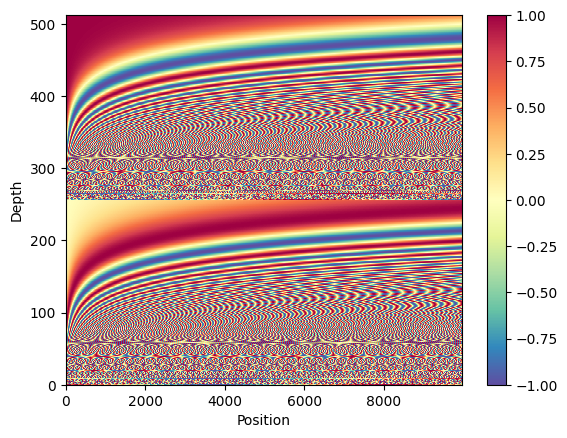

In [29]:
pos_encoding = positional_encoding(length=VOCAB_SIZE, depth=D_MODEL)

# Check the shape.
print(pos_encoding.shape)

# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='Spectral_r')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

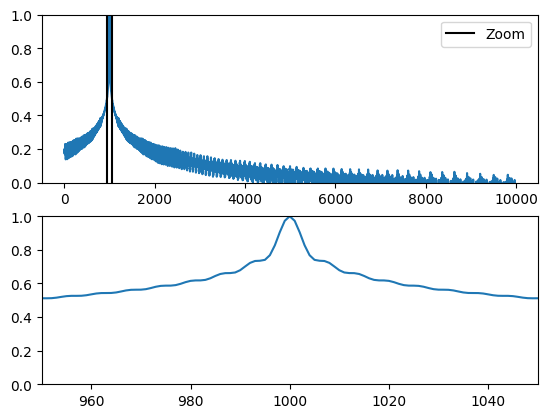

In [30]:
pos_encoding/=tf.norm(pos_encoding, axis=1, keepdims=True)
p = pos_encoding[1000]
dots = tf.einsum('pd,d -> p', pos_encoding, p)
plt.subplot(2,1,1)
plt.plot(dots)
plt.ylim([0,1])
plt.plot([950, 950, float('nan'), 1050, 1050],
         [0,1,float('nan'),0,1], color='k', label='Zoom')
plt.legend()
plt.subplot(2,1,2)
plt.plot(dots)
plt.xlim([950, 1050])
plt.ylim([0,1])
plt.show()

In [31]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=vocab_size, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [32]:
embed_pt = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)
embed_en = PositionalEmbedding(vocab_size=VOCAB_SIZE, d_model=D_MODEL)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)
en_emb._keras_mask[0]

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False])>

#### The base attention layer

In [33]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

#### The cross attention layer

In [34]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)

    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [35]:
sample_ca = CrossAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(pt_emb.shape)
print(en_emb.shape)
print(sample_ca(en_emb, pt_emb).shape)

(64, 20, 512)
(64, 20, 512)
(64, 20, 512)


#### The global self attention layer

In [36]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [37]:
sample_gsa = GlobalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(pt_emb.shape)
print(sample_gsa(pt_emb).shape)

(64, 20, 512)
(64, 20, 512)


#### The causal self attention layer

In [38]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [39]:
sample_csa = CausalSelfAttention(num_heads=NUM_HEADS, key_dim=D_MODEL)

print(en_emb.shape)
print(sample_csa(en_emb).shape)

(64, 20, 512)
(64, 20, 512)


In [40]:
out1 = sample_csa(embed_en(en[:, :3])) 
out2 = sample_csa(embed_en(en))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

5.9604645e-07

#### The feed forward network

In [41]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [42]:
sample_ffn = FeedForward(D_MODEL, DFF)

print(en_emb.shape)
print(sample_ffn(en_emb).shape)

(64, 20, 512)
(64, 20, 512)


#### The encoder layer

In [43]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [44]:
sample_encoder_layer = EncoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

print(pt_emb.shape)
print(sample_encoder_layer(pt_emb).shape)

(64, 20, 512)
(64, 20, 512)


In [45]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1, **kwargs):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [46]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

sample_encoder_output = sample_encoder(pt, training=False)

# Print the shape.
print(pt.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 20)
(64, 20, 512)


#### The decoder layer

In [47]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [48]:
sample_decoder_layer = DecoderLayer(d_model=D_MODEL, num_heads=NUM_HEADS, dff=DFF)

sample_decoder_layer_output = sample_decoder_layer(
    x=en_emb, context=pt_emb)

print(en_emb.shape)
print(pt_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(64, 20, 512)
(64, 20, 512)
(64, 20, 512)


In [49]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [50]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=NUM_LAYERS,
                         d_model=D_MODEL,
                         num_heads=NUM_HEADS,
                         dff=DFF,
                         vocab_size=VOCAB_SIZE)

output = sample_decoder(
    x=en,
    context=pt_emb)

# Print the shapes.
print(en.shape)
print(pt_emb.shape)
print(output.shape)

(64, 20)
(64, 20, 512)
(64, 20, 512)


#### The Transformer

In [51]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

In [52]:
transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    dropout_rate=DROPOUT)

In [53]:
output = transformer((pt, en))

print(en.shape)
print(pt.shape)
print(output.shape)

(64, 20)
(64, 20)
(64, 20, 9980)


In [54]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)  # (batch, heads, target_seq, input_seq)

(64, 4, 20, 20)


In [55]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  14041600  
                                                                 
 decoder_1 (Decoder)         multiple                  22445568  
                                                                 
 dense_22 (Dense)            multiple                  5119740   
                                                                 
Total params: 41,606,908
Trainable params: 41,606,908
Non-trainable params: 0
_________________________________________________________________


### Training

#### Set up the optimizer

In [56]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=2000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [57]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

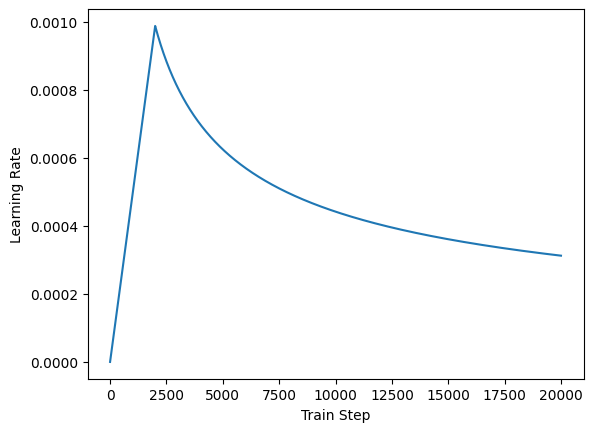

In [58]:
plt.plot(learning_rate(tf.range(20000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')
plt.show()

In [59]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

#### Train the model

In [60]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [61]:
%%time
t_tistory = transformer.fit(train_batches,
                epochs=EPOCHS,
                validation_data=val_batches)

Epoch 1/10
729/729 [==============================] - 139s 173ms/step - loss: 6.1807 - masked_accuracy: 0.2191 - val_loss: 4.8250 - val_masked_accuracy: 0.3093
Epoch 2/10
729/729 [==============================] - 100s 137ms/step - loss: 4.3334 - masked_accuracy: 0.3397 - val_loss: 4.1106 - val_masked_accuracy: 0.3523
Epoch 3/10
729/729 [==============================] - 99s 136ms/step - loss: 3.7598 - masked_accuracy: 0.3674 - val_loss: 3.9266 - val_masked_accuracy: 0.3586
Epoch 4/10
729/729 [==============================] - 99s 135ms/step - loss: 3.2629 - masked_accuracy: 0.4008 - val_loss: 3.6909 - val_masked_accuracy: 0.3796
Epoch 5/10
729/729 [==============================] - 99s 136ms/step - loss: 2.7084 - masked_accuracy: 0.4540 - val_loss: 3.6359 - val_masked_accuracy: 0.3938
Epoch 6/10
729/729 [==============================] - 99s 136ms/step - loss: 2.2159 - masked_accuracy: 0.5184 - val_loss: 3.6725 - val_masked_accuracy: 0.4038
Epoch 7/10
729/729 [========================

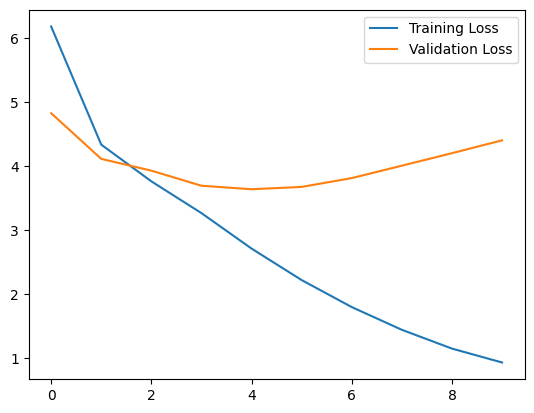

In [62]:
plt.plot(t_tistory.history["loss"], label="Training Loss")
plt.plot(t_tistory.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [63]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # ÎîîÏΩîÎçîÏùò ÏòàÏ∏° ÏãúÏûë
  for i in range(MAX_LENGTH):
    predictions = transformer(inputs=[sentence, output], training=False)

    # ÌòÑÏû¨(ÎßàÏßÄÎßâ) ÏãúÏ†êÏùò ÏòàÏ∏° Îã®Ïñ¥Î•º Î∞õÏïÑÏò®Îã§.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # ÎßåÏïΩ ÎßàÏßÄÎßâ ÏãúÏ†êÏùò ÏòàÏ∏° Îã®Ïñ¥Í∞Ä Ï¢ÖÎ£å ÌÜ†ÌÅ∞Ïù¥ÎùºÎ©¥ ÏòàÏ∏°ÏùÑ Ï§ëÎã®
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # ÎßàÏßÄÎßâ ÏãúÏ†êÏùò ÏòàÏ∏° Îã®Ïñ¥Î•º Ï∂úÎ†•Ïóê Ïó∞Í≤∞ÌïúÎã§.
    # Ïù¥Îäî forÎ¨∏ÏùÑ ÌÜµÌï¥ÏÑú ÎîîÏΩîÎçîÏùò ÏûÖÎ†•ÏúºÎ°ú ÏÇ¨Ïö©Îê† ÏòàÏ†ïÏù¥Îã§.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('ÏßàÎ¨∏ : "{}"'.format(sentence))
  print('ÎãµÎ≥Ä : "{}"'.format(predicted_sentence))

  return predicted_sentence

def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

### Test Chat

In [64]:
%%time
output = predict('Ï∑®ÏóÖÌïòÍ∏∞ ÏúÑÌï¥ÏÑú Ïó¥Ïã¨Ìûà Ï§ÄÎπÑÌïòÍ≥† ÏûàÏßÄÎßå, ÏßÅÏû•ÏùÑ Íµ¨ÌïòÏßÄ Î™ªÌï†ÍπåÎ¥ê Í±±Ï†ïÎêò')

ÏßàÎ¨∏ : "Ï∑®ÏóÖÌïòÍ∏∞ ÏúÑÌï¥ÏÑú Ïó¥Ïã¨Ìûà Ï§ÄÎπÑÌïòÍ≥† ÏûàÏßÄÎßå, ÏßÅÏû•ÏùÑ Íµ¨ÌïòÏßÄ Î™ªÌï†ÍπåÎ¥ê Í±±Ï†ïÎêò"
ÎãµÎ≥Ä : "Ï∑®ÏóÖ Ï§ÄÎπÑÎ°ú Í±±Ï†ïÏù¥ ÎßéÏúºÏãúÍµ∞Ïöî ."
CPU times: user 639 ms, sys: 99.8 ms, total: 739 ms
Wall time: 764 ms


In [65]:
%%time
output = predict('Îî∏Ïù¥ ÎÇòÏóêÍ≤å ÏÑ†Î¨ºÏùÑ Ï§¨Ïñ¥. Í∑∏ÎûòÏÑú ÎÑàÎ¨¥ Í∏∞Îªê')

ÏßàÎ¨∏ : "Îî∏Ïù¥ ÎÇòÏóêÍ≤å ÏÑ†Î¨ºÏùÑ Ï§¨Ïñ¥. Í∑∏ÎûòÏÑú ÎÑàÎ¨¥ Í∏∞Îªê"
ÎãµÎ≥Ä : "Îî∏Ïù¥ ÏÑ†Î¨ºÏùÑ Ï§òÏÑú Í∏∞ÏÅòÏãúÍµ∞Ïöî ."
CPU times: user 547 ms, sys: 62.6 ms, total: 610 ms
Wall time: 638 ms


In [66]:
%%time
output = predict('ÎÑàÎäî ÎàÑÍµ¨Îãà?')

ÏßàÎ¨∏ : "ÎÑàÎäî ÎàÑÍµ¨Îãà?"
ÎãµÎ≥Ä : "Ï†ÄÎäî Ïù¥Ïó∞Ï§ÄÎãòÏùò Ï±óÎ¥á Ïù¥ÎùºÍ≥† Ìï©ÎãàÎã§ ."
CPU times: user 1.58 s, sys: 124 ms, total: 1.7 s
Wall time: 1.78 s


In [67]:
%%time
output = predict('ÏïÑÎ¨¥Î¶¨ ÏÉùÍ∞ÅÌï¥ÎèÑ ÎÑàÎäî Î©çÏ≤≠Ìïú Í≤É Í∞ôÏïÑ')

ÏßàÎ¨∏ : "ÏïÑÎ¨¥Î¶¨ ÏÉùÍ∞ÅÌï¥ÎèÑ ÎÑàÎäî Î©çÏ≤≠Ìïú Í≤É Í∞ôÏïÑ"
ÎãµÎ≥Ä : "ÏùºÏ¢ÖÏùò Ïï†Ïì∞Îäî Í≤ÉÏúºÎ°ú Ïù∏Ìï¥ Ïó¥Îì±Í∞êÏùÑ ÎäêÎÅºÏãúÎäîÍµ∞Ïöî ."
CPU times: user 1.18 s, sys: 7.25 ms, total: 1.19 s
Wall time: 1.24 s
